<a href="https://colab.research.google.com/github/MDIL-SNU/sevennet_tutorial/blob/main/notebooks/SevenNet_finetune_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SevenNet tutorial: finetuning + python interactive

---
This notebook is a python interactive tutorial for finetuning SevenNet-0.\
It continues from `SevenNet_python_tutorial.ipynb`, but can be thought as an isolated tutorial also.\
[paper](https://pubs.acs.org/doi/10.1021/acs.jctc.4c00190)\
[code](https://github.com/MDIL-SNU/SevenNet) \
We recommend using a GPU. If you're using Colab, go to:\
[Runtime] -> [Change runtime type] -> [T4 GPU] -> [Save]

If you're using Colab, it may crash occasionally. If it does, try starting from the beginning or from the cell where it crashed. If that doesn’t work, go to: \
[Runtime] -> [Disconnect and delete runtime] -> restart!

## 0. Installation
First of all, let's install SevenNet to our computer!

In [1]:
# Install SevenNet
!pip install sevenn

# If you want to check the SevenNet code, clone the repo.
# !git clone https://github.com/MDIL-SNU/SevenNet.git

import os
working_dir = os.getcwd() # save current path

In [2]:
# check if sevenn is installed well
import sevenn
sevenn.__version__

'0.10.1'

## 1. Prepare dataset to fine-tune 7net-0

In [16]:
import os.path

data_path = './data'
if not os.path.exists(data_path):
    # If you have this notebook file only, (or using colab) download the dataset
    !git clone https://github.com/MDIL-SNU/sevennet_tutorial.git
    data_path = 'sevennet_tutorial/data'

assert os.path.exists(data_path) and os.path.exists(os.path.join(data_path, 'train'))

Cloning into 'sevennet_tutorial'...
remote: Enumerating objects: 66, done.
remote: Counting objects: 100% (66/66), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 66 (delta 16), reused 61 (delta 14), pack-reused 0 (from 0)
Unpacking objects: 100% (66/66), 5.28 MiB | 6.99 MiB/s, done.


In [4]:
import sevenn.util as util
from sevenn.nn.scale import SpeciesWiseRescale
sevennet_0_cp_path = util.pretrained_name_to_path('7net-0')
model, config = util.model_from_checkpoint(sevennet_0_cp_path)

# To enhance training speed, we will overwrite shift scale module to trainable
# By making energy shift trainable, error quickly converges.
shift_scale_module = model._modules['rescale_atomic_energy']
shift = shift_scale_module.shift.tolist()
scale = shift_scale_module.scale.tolist()
model._modules['rescale_atomic_energy'] = SpeciesWiseRescale(
    shift=shift,
    scale=scale,
    train_shift_scale=True,
)
print(model)

AtomGraphSequential(
  (edge_embedding): EdgeEmbedding(
    (basis_function): BesselBasis()
    (cutoff_function): XPLORCutoff()
    (spherical): SphericalEncoding(
      (sph): SphericalHarmonics()
    )
  )
  (onehot_idx_to_onehot): OnehotEmbedding()
  (onehot_to_feature_x): IrrepsLinear(
    (linear): Linear(89x0e -> 128x0e | 11392 weights)
  )
  (0_self_connection_intro): SelfConnectionLinearIntro(
    (linear): Linear(128x0e -> 224x0e+64x1e+32x2e | 28672 weights)
  )
  (0_self_interaction_1): IrrepsLinear(
    (linear): Linear(128x0e -> 128x0e | 16384 weights)
  )
  (0_convolution): IrrepsConvolution(
    (convolution): TensorProduct(128x0e x 1x0e+1x1e+1x2e -> 128x0e+128x1e+128x2e | 384 paths | 384 weights)
    (weight_nn): FullyConnectedNet[8, 64, 64, 384]
  )
  (0_self_interaction_2): IrrepsLinear(
    (linear): Linear(128x0e+128x1e+128x2e -> 224x0e+64x1e+32x2e | 40960 weights)
  )
  (0_self_connection_outro): SelfConnectionOutro()
  (0_equivariant_gate): EquivariantGate(
    (g

### Dataset setting

In [5]:
import os
from sevenn.train.graph_dataset import SevenNetGraphDataset

working_dir = os.getcwd() # change if you want
train_dir = os.path.join(data_path, 'train/')
xyz_files = ['1200K.extxyz', '600K.extxyz']
dataset_files = [os.path.join(train_dir, xyz) for xyz in xyz_files]

cutoff = config['cutoff']  # 7net-0 uses 5.0 Angstrom cutoff
# Preprocess(build graphs) data before training. It will automatically saves processed graph to {root}/sevenn_data/train.pt, metadata + statistics as train.yaml
# If you run below code on more time, it will load saved train.pt automatically instread of rebuilding graph.
# If you have changed your data for some reason, put 'force_reload=True' to reload dataset. Or put processed_name other than
dataset = SevenNetGraphDataset(cutoff=cutoff, root=working_dir, files=dataset_files, processed_name='train.pt')

print(f'# graphs: {len(dataset)}')
print(f'# atoms (nodes): {dataset.natoms}')
print(dataset[0])

# graphs: 170
# atoms (nodes): {'Cl': 5440, 'Li': 32640, 'P': 5440, 'S': 27200, 'total': 70720}
AtomGraphData(
  x=[416],
  edge_index=[2, 11254],
  pos=[416, 3],
  node_attr=[416],
  atomic_numbers=[416],
  edge_vec=[11254, 3],
  total_energy=[1],
  force_of_atoms=[416, 3],
  stress=[1, 6],
  cell_lattice_vectors=[3, 3],
  pbc_shift=[11254, 3],
  cell_volume=[1],
  num_atoms=[1],
  per_atom_energy=[1],
  data_info={}
)


In [6]:
from torch_geometric.loader import DataLoader

# split the dataset into train & valid
# We will use only 25% of original dataset (from_scratch used 95% of it). For fine-tuning.
# Fine-tuning is significantly data efficient than from-scratch!
num_dataset = len(dataset)
num_train = int(num_dataset * 0.25)
num_valid = 10

dataset = dataset.shuffle()
train_dataset = dataset[:num_train]
valid_dataset = dataset[num_train:num_train + 10]

print(f'# graphs for training: {len(train_dataset)}')
print(f'# graphs for validation: {len(valid_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4)

# graphs for training: 42
# graphs for validation: 10


### Model setting

### Start training
If you want more accurate model, increase the num_epoch!

In [7]:
from sevenn.train.trainer import Trainer
import torch.optim.lr_scheduler as scheduler

config.update({
    'optimizer': 'adam',
    'optim_param': {'lr': 0.004},
    'scheduler': 'linearlr',
    'scheduler_param': {'start_factor': 1.0, 'total_iters': 10, 'end_factor': 0.0001},
    'is_ddp': False,  # 7net-0 is traied with ddp=True. We override this key False as we won't use it
})
trainer = Trainer.from_config(model, config)

# We have energy, force, stress loss function, which used to train 7net-0.
# We will use it as it is, with loss weight: 1.0, 1.0, and 0.01 for energy, force, and stress, respectively.
print(trainer.loss_functions)
print(trainer.optimizer)
print(trainer.scheduler)

[(Energy, 1.0), (Force, 1.0), (Stress, 0.01)]
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.004
    lr: 0.004
    maximize: False
    weight_decay: 0
)


In [8]:
from copy import deepcopy
from sevenn.error_recorder import ErrorRecorder

train_recorder = ErrorRecorder.from_config(config)
valid_recorder = deepcopy(train_recorder)
for metric in train_recorder.metrics:
  print(metric)

Energy_RMSE (eV/atom): nan
Force_RMSE (eV/Å): nan
Stress_RMSE (kbar): nan
Energy_MAE (eV/atom): nan
Force_MAE (eV/Å): nan
Stress_MAE (kbar): nan
Energy_Loss: nan
Force_Loss: nan
Stress_Loss: nan
TotalLoss: nan


In [9]:
from sevenn.sevenn_logger import Logger

valid_best = float('inf')
total_epoch = 10

logger = Logger()
logger.screen = True

# As error recorder is long, let's use sevennet_logger for pretty print
# It is similar to outputs when using sevennet with terminal.
with logger:
    logger.greeting()  # prints ascii logo
    for epoch in range(1, total_epoch + 1):  # ~ 16 sec/epoch with RTX4060
        logger.timer_start('epoch')
        logger.writeline(f'Epoch {epoch}/{total_epoch}  Learning rate: {trainer.get_lr():.6f}')
        # trainer scans whole data from given loader, and updates error recorder with outputs.
        trainer.run_one_epoch(train_loader, is_train=True, error_recorder=train_recorder)
        trainer.run_one_epoch(valid_loader, is_train=False, error_recorder=valid_recorder)
        trainer.scheduler_step()
        train_err = train_recorder.epoch_forward()  # return averaged error over one epoch, then reset.
        valid_err = valid_recorder.epoch_forward()
        logger.bar()
        logger.write_full_table([train_err, valid_err], ['Train', 'Valid'])
        logger.timer_end('epoch', message=f'Epoch {epoch} elapsed')

trainer.write_checkpoint(os.path.join(working_dir, 'checkpoint_fine_tuned.pth'), config=config, epoch=total_epoch)

SevenNet: Scalable EquVariance-Enabled Neural Network
version 0.10.1, Fri Nov  8 11:48:41 2024
this file: None
reading yaml config...
                ****
              ********                                   .
              *//////,  ..                               .            ,*.
               ,,***.         ..                        ,          ********.                                  ./,
             .      .                ..   /////.       .,       . */////////                               /////////.
        .&@&/        .                  .(((((((..     /           *//////*.  ...                         *((((((((((.
     @@@@@@@@@@*    @@@@@@@@@@  @@@@@    *((@@@@@     (     %@@@@@@@@@@  .@@@@@@     ..@@@@.   @@@@@@*    .(@@@@@(((*
    @@@@@.          @@@@         @@@@@ .   @@@@@      #     %@@@@         @@@@@@@@     @@@@(,  @@@@@@@@.    @@@@@(*.
    %@@@@@@@&       @@@@@@@@@@    @@@@@   @@@@@      #  ., .%@@@@@@@@@    @@@@@@@@@@   @@@@,   @@@@@@@@@@   @@@@@
    ,(%@@@@@

## 3. Model test
### Energy / force plot
Let's predict the energy and force of training/test dataset and draw the parity plots

In [11]:
# load test model
import os
working_dir = './'

# If you have this notebook file only, (or using colab) download the dataset
# !git clone https://github.com/MDIL-SNU/sevennet_tutorial.git
# data_path = 'sevennet_tutorial/data'

# If you have downloaded git repository (sevennet_tutorial), set data path
data_path = './data'
assert os.path.exists(data_path) and os.path.exists(os.path.join(data_path, 'evaluation'))

import torch
import ase.io

from sevenn.sevennet_calculator import SevenNetCalculator

# Let's test our model by predicting DFT MD trajectory
# Instead of using other functions in SevenNet, we will use ASE calculator as an interface of our model
DFT_md_xyz = os.path.join(data_path, 'evaluation/test_md.extxyz')

# initialize calculator from checkpoint.
fine_tuned_calc = SevenNetCalculator(os.path.join(working_dir, 'checkpoint_fine_tuned.pth'))
sevennet_0_calc = SevenNetCalculator('7net-0')  # As a baseline

# load DFT md trajectory
traj = ase.io.read(DFT_md_xyz, index=':')

In [12]:
import numpy as np
from tqdm import tqdm

dft_energy, dft_forces, dft_stress = [], [], []
ft_energy, ft_forces, ft_stress = [], [], []
base_energy, base_forces, base_stress = [], [], []
to_kBar = 1602.1766208

for atoms in tqdm(traj):
  atoms.calc = fine_tuned_calc
  ft_energy.append(atoms.get_potential_energy() / len(atoms))  # as per atom energy
  ft_forces.append(atoms.get_forces())
  ft_stress.extend(-1 * atoms.get_stress() * to_kBar)  # eV/Angstrom^3 to kBar unit

  atoms.calc = sevennet_0_calc
  base_energy.append(atoms.get_potential_energy() / len(atoms))  # as per atom energy
  base_forces.append(atoms.get_forces())
  base_stress.extend(-1 * atoms.get_stress() * to_kBar)

  dft_energy.append(atoms.info['DFT_energy'] / len(atoms))
  dft_forces.append(atoms.arrays['DFT_forces'])
  dft_stress.append(-1 * atoms.info['DFT_stress'] * to_kBar)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:39<00:00,  2.55it/s]


In [13]:
# flatten forces and stress for parity plot
ft_forces = np.concatenate([f.reshape(-1,) for f in ft_forces])
ft_stress = np.concatenate([s.reshape(-1,) for s in ft_stress])

base_forces = np.concatenate([f.reshape(-1,) for f in base_forces])
base_stress = np.concatenate([s.reshape(-1,) for s in base_stress])

dft_forces = np.concatenate([f.reshape(-1,) for f in dft_forces])
dft_stress = np.concatenate([s.reshape(-1,) for s in dft_stress])

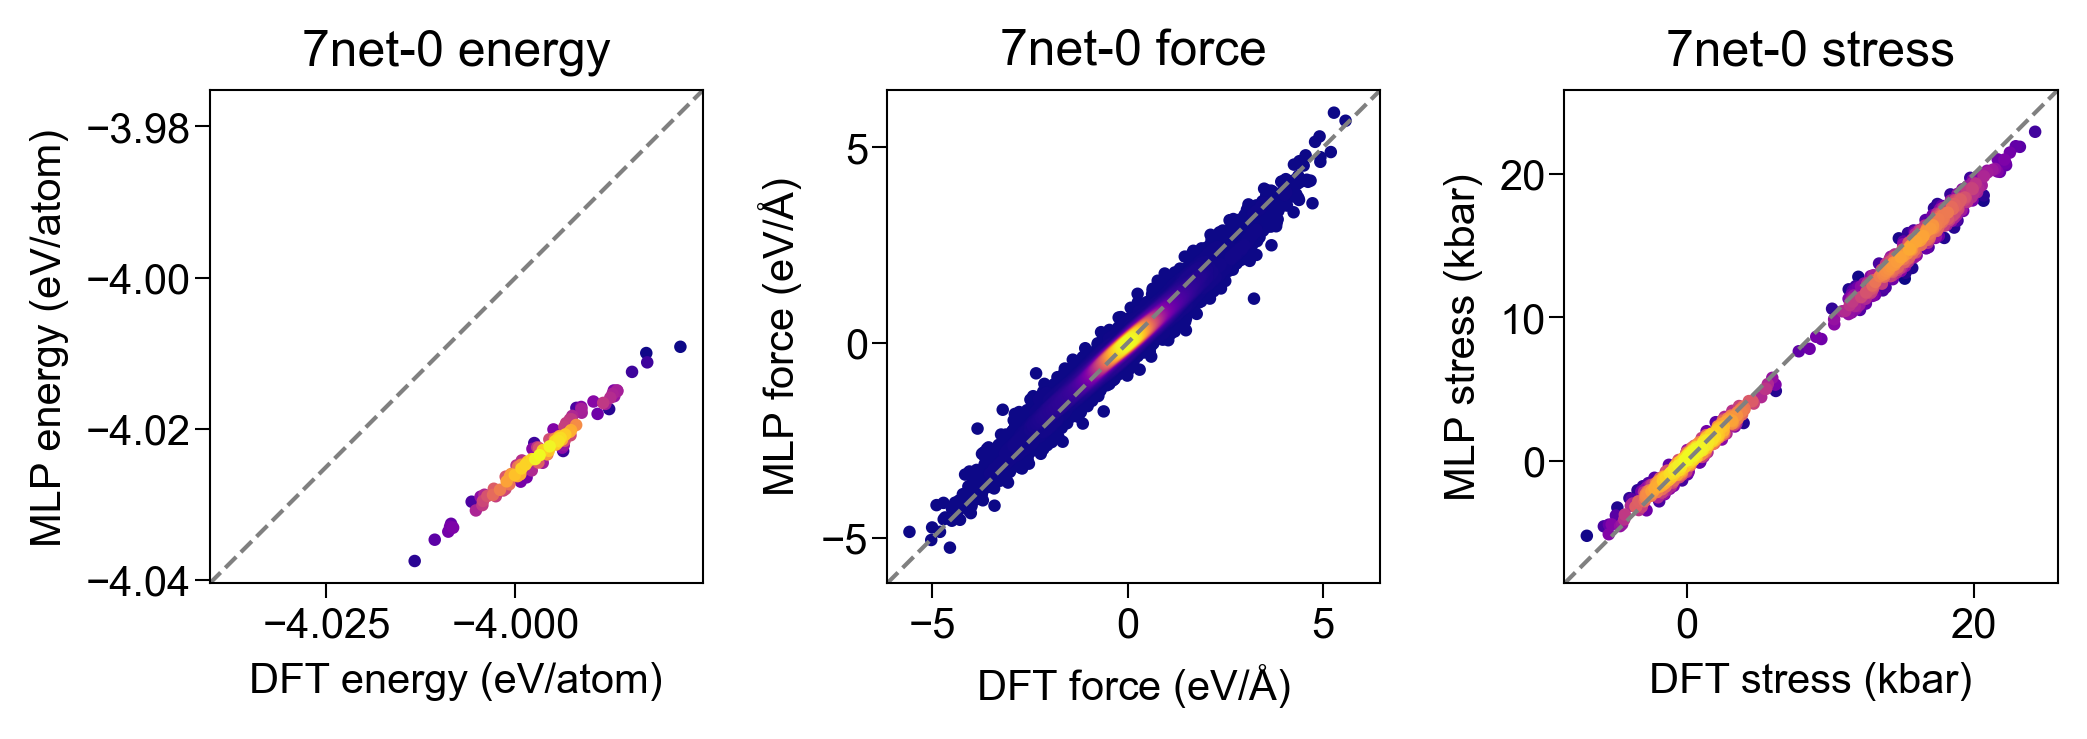

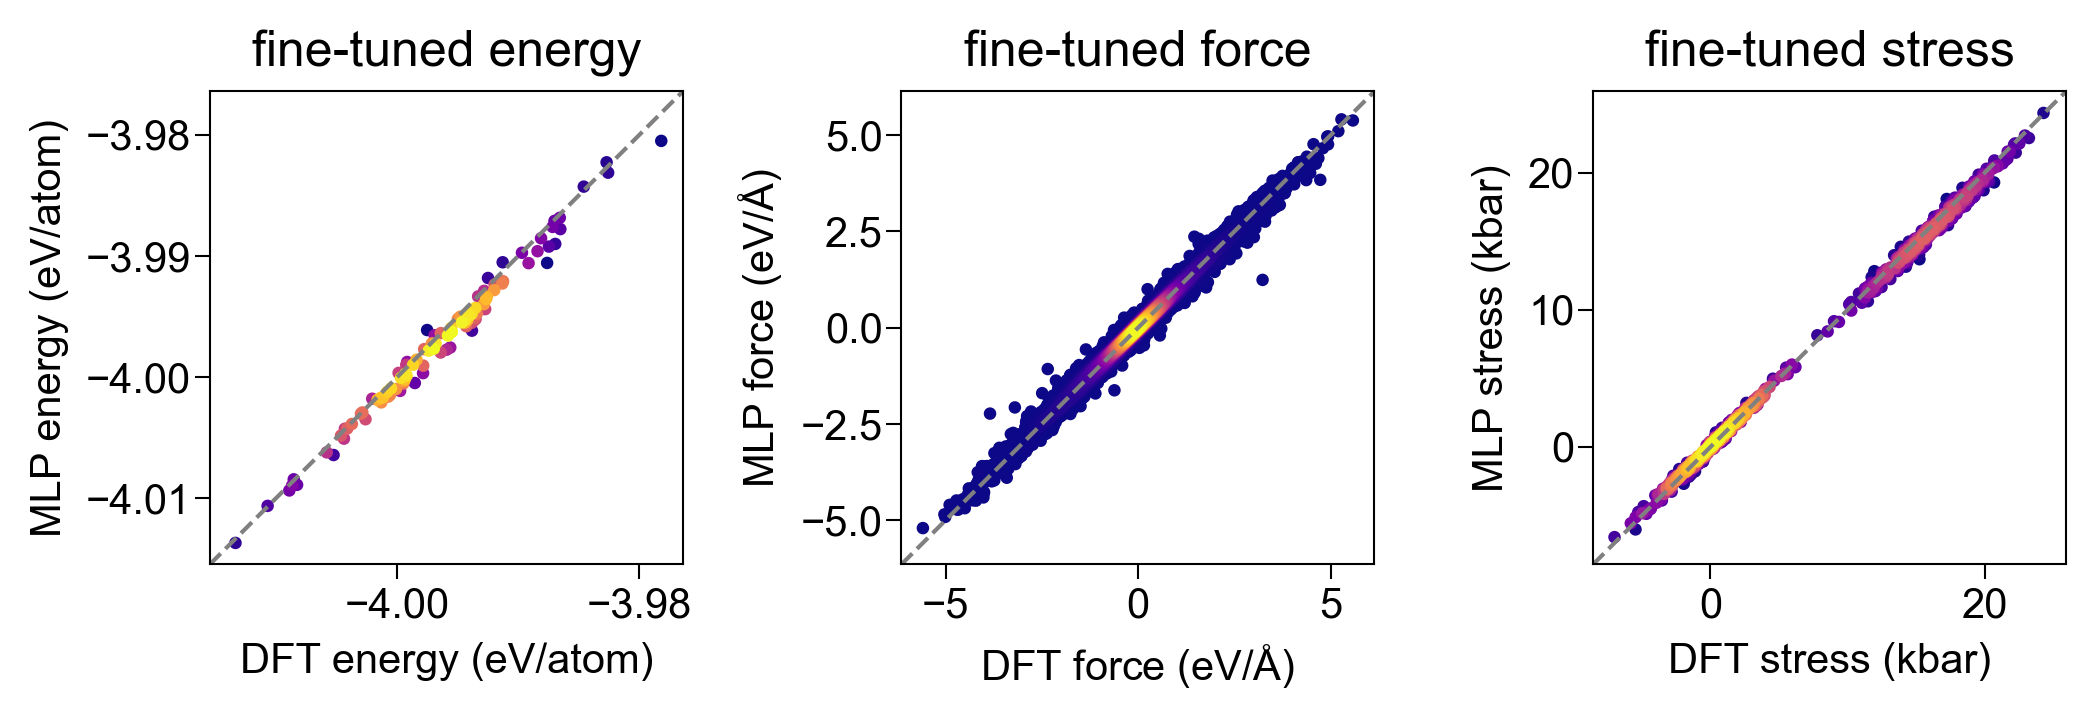

In [14]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# draw a parity plot of energy / force / stress
unit = {"energy": "eV/atom", "force": r"eV/$\rm{\AA}$", "stress": "kbar"}
def density_colored_scatter_plot(dft_energy, nnp_energy, dft_force, nnp_force, dft_stress, nnp_stress, title=None):
    modes = ['energy', 'force', 'stress']
    plt.figure(figsize=(18/2.54, 6/2.54))
    for num, (x, y) in enumerate(zip([dft_energy, dft_force, dft_stress], [nnp_energy, nnp_force, nnp_stress])):
        mode = modes[num]
        idx = np.random.choice(len(x), 1000) if len(x) > 1000 else list(range(len(x)))
        xsam = [x[i] for i in idx]
        ysam = [y[i] for i in idx]
        xy = np.vstack([x, y])
        xysam = np.vstack([xsam, ysam])
        zsam = gaussian_kde(xysam)

        z = zsam.pdf(xy)
        idx = z.argsort()

        x = [x[i] for i in idx]
        y = [y[i] for i in idx]
        z = [z[i] for i in idx]

        ax = plt.subplot(int(f'13{num+1}'))
        plt.scatter(x, y, c=z, s=4, cmap='plasma')

        mini = min(min(x), min(y))
        maxi = max(max(x), max(y))
        ran = (maxi-mini) / 20
        plt.plot([mini-ran, maxi+ran], [mini-ran, maxi+ran], color='grey', linestyle='dashed')
        plt.xlim(mini-ran, maxi+ran)
        plt.ylim(mini-ran, maxi+ran)

        plt.xlabel(f'DFT {mode} ({unit[mode]})')
        plt.ylabel(f'MLP {mode} ({unit[mode]})')
        ax.set_aspect('equal')
        if title:
          ax.set_title(f'{title} {mode}')
    plt.tight_layout()
    plt.show()

density_colored_scatter_plot(dft_energy, base_energy, dft_forces, base_forces, dft_stress, base_stress, '7net-0')
density_colored_scatter_plot(dft_energy, ft_energy, dft_forces, ft_forces, dft_stress, ft_stress, 'fine-tuned')